In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import stats
from collections import deque

In [ ]:
"""
for google colab support
"""

from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/BA/CSV-Files '

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['Untitled0.ipynb', 'cities.csv', 'disease_counters.csv', 'edges.csv', 'node_positions.csv', 'pandemic_all_strategies_results.csv', 'pandemic_baseline_results.csv']


In [ ]:
# Load CSV files
cities_df = pd.read_csv('cities.csv', index_col='City')
disease_counters_df = pd.read_csv('disease_counters.csv', index_col='City')
edges_df = pd.read_csv('edges.csv')
positions_df = pd.read_csv('node_positions.csv', index_col='City')

# **Game board construction**

---


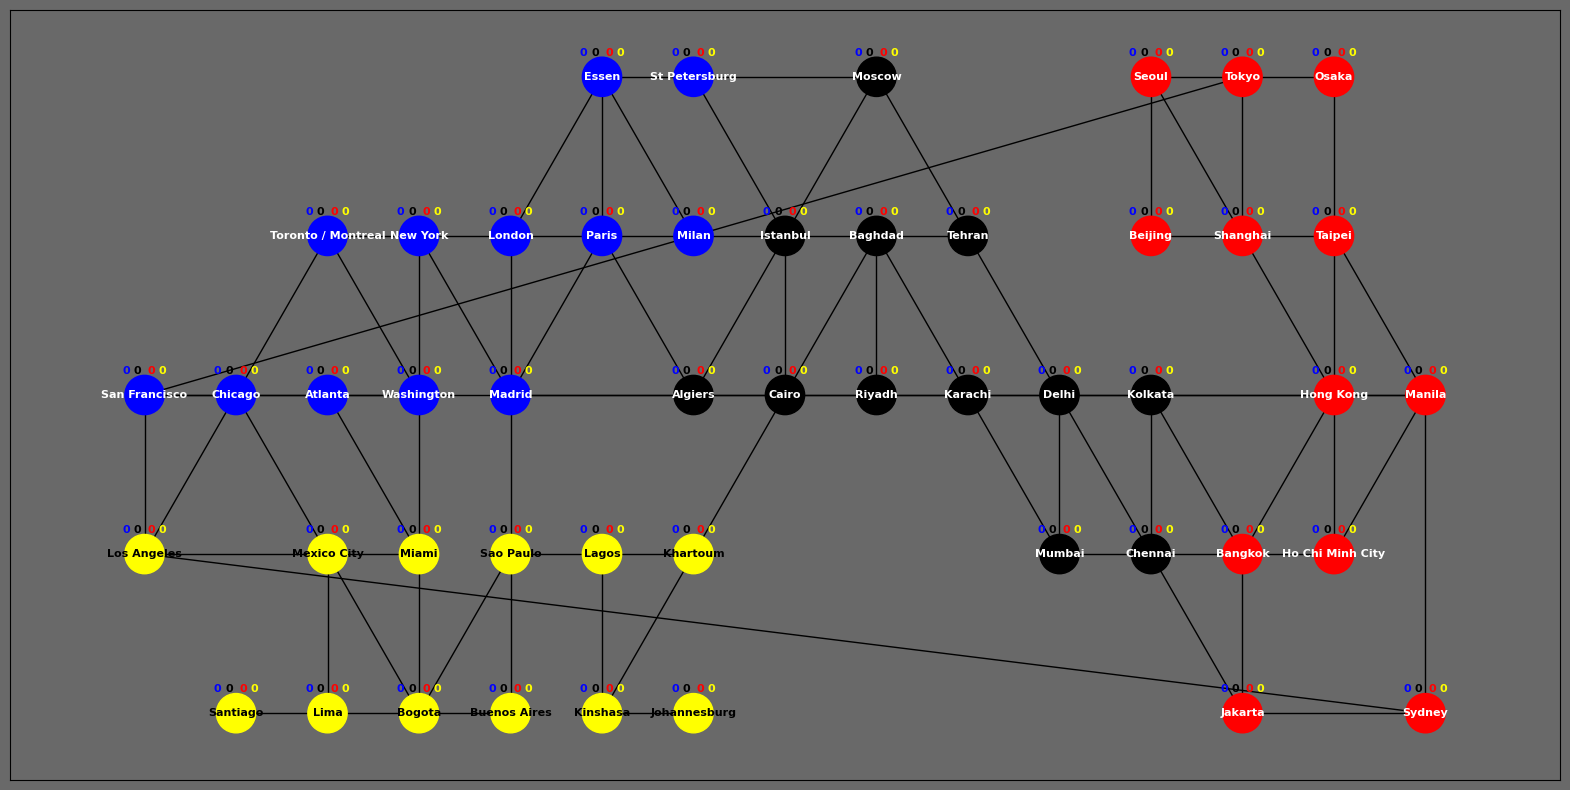

In [ ]:
# Create an empty graph
Graph_gameboard = nx.Graph()

# Add nodes with attributes
for city, color in cities_df['Color'].items():
    Graph_gameboard.add_node(city, color=color)

# Add edges from DataFrame
Graph_gameboard.add_edges_from(edges_df.values)

# Set node attributes for disease counters
for city, counters in disease_counters_df.iterrows():
    Graph_gameboard.nodes[city]['disease_counters'] = counters.to_dict()

# Define node positions
node_positions = positions_df.apply(tuple, axis=1).to_dict()

fig, ax = plt.subplots(figsize=(20, 10))

node_colors = [cities_df.loc[city, 'Color'] for city in Graph_gameboard.nodes()]

# change font of nodes with yellow color
yellow_nodes = [city for city, color in cities_df['Color'].items() if color == 'yellow']
font_colors = {city: 'black' if city in yellow_nodes else 'white' for city in Graph_gameboard.nodes()}

# Draw the nodes
nx.draw_networkx_nodes(Graph_gameboard, pos=node_positions, node_color=node_colors, node_size=800)

# Draw the edges
nx.draw_networkx_edges(Graph_gameboard, pos=node_positions)

# Add labels manually with specified colors
for node, (x, y) in node_positions.items():
    plt.text(x, y, node, fontsize=8, ha='center', va='center', color=font_colors[node], weight='bold')

ax.set_facecolor('#696969')
fig.set_facecolor('#696969')

font_colors_disease_counter = {city: 'black' if city in yellow_nodes else 'white' for city in Graph_gameboard.nodes()}

for node, (x, y) in node_positions.items():
    counters = Graph_gameboard.nodes[node]['disease_counters']

    # Construct labels for each counter with its color
    blue_label = f"{counters['blue']}"
    black_label = f"{counters['black']}"
    red_label = f"{counters['red']}"
    yellow_label = f"{counters['yellow']}"

    # Draw the text for each counter with its color
    plt.text(x - 4, y + 3, blue_label, fontsize=8, ha='center', va='center', color='blue', weight='bold')
    plt.text(x - 1.5, y + 3, black_label, fontsize=8, ha='center', va='center', color='black', weight='bold')
    plt.text(x + 1.5, y + 3, red_label, fontsize=8, ha='center', va='center', color='red', weight='bold')
    plt.text(x + 4, y + 3, yellow_label, fontsize=8, ha='center', va='center', color='yellow', weight='bold')

plt.show()

# **Helperfunctions**

---

In [ ]:
#@title initialize_pandemic_model
# Initialize the infected cities
def initialize_pandemic_model(graph, strategy, k_action = 4, epidemic_cards = 6, nodes_to_infect_at_start = 3):
    # 96 Cubes 24 in 4 Colors
    # 48 cities
    # 6 Epidemic card
    # Infection rate 7 tiles, (2,2,2,3,3,4,4)
    # Outbreak marker 8 tiles

    # Get and shuffle all Nodes
    num_nodes = graph.number_of_nodes()
    all_nodes = list(graph.nodes)
    random.shuffle(all_nodes)

    # Initialize stacks
    infection_discard_stack = deque()
    infection_stack = deque(all_nodes)
    player_stack = deque()

    # k Nodes to infect at the start (Pandemic normal value is always 3x3, 3x2, 3x1 total 9 nodes)
    # Needs to be set to 3 so we do 3 times the different infection counts
    k_nodes_to_infect = nodes_to_infect_at_start

    # Set the amount of epidemic cards (4,5,6 Pandemic)
    epidemics = epidemic_cards

    infection_rate = [2, 2, 2, 3, 3, 4, 4]
    infection_rate_counter = 0
    outbreak_counter = 0

    k_actions = k_action

    # Set the disinfection strategy
    disinfection_strategy = strategy

    # -------------------------------
    # Start of Epidemic Cards Setup
    # -------------------------------
    if not epidemics == 0:

        # Calculate the chunk size for the epidemics (Floor division)
        chunk_size = num_nodes // epidemics

        # Add chunks with one epidemic node to the player deck
        for i in range(epidemics):
            if i == epidemics - 1:
                chunk = random.sample(all_nodes, len(all_nodes))
            else:
                chunk = random.sample(all_nodes, chunk_size)

            chunk.extend(["Epidemic"])
            random.shuffle(chunk)
            player_stack.extend(chunk)

            # Remove nodes used in this chunk
            all_nodes = list(set(all_nodes) - set(chunk))
    else:
        chunk = random.sample(all_nodes, len(all_nodes))
        random.shuffle(chunk)
        player_stack.extend(chunk)

    #while (epidemics == 1 or epidemics == 2) and player_stack[-1] == "Epidemic":
        #random.shuffle(player_stack)

    # Shuffle the deque in-place
    #random.shuffle(player_stack)
    # -------------------------------
    # End of Epidemic Cards Setup
    # -------------------------------

    # -------------------------------
    # Start of Node infection
    # -------------------------------

    # Infect k nodes with 3 disease counters (blue)
    for _ in range(k_nodes_to_infect):
        node = infection_stack.pop()
        graph.nodes[node]["disease_counters"]["blue"] = 3
        infection_discard_stack.append(node)

    # Infect k nodes with 2 disease counters (blue)
    for _ in range(k_nodes_to_infect):
        node = infection_stack.pop()
        graph.nodes[node]["disease_counters"]["blue"] = 2
        infection_discard_stack.append(node)

    # Infect k nodes with 1 disease counter (blue)
    for _ in range(k_nodes_to_infect):
        node = infection_stack.pop()
        graph.nodes[node]["disease_counters"]["blue"] = 1
        infection_discard_stack.append(node)

    # Set the remaining nodes to have 0 disease counters
    for node in infection_stack:
        graph.nodes[node]["disease_counters"]["blue"] = 0

    # -------------------------------
    # End of Node infection
    # -------------------------------

    # Set node attributes
    #nx.set_node_attributes(graph, 0, "disease_counters")

    # Initialize the sisr_model
    pandemic_model = {"graph": graph,
                      "infection_stack": infection_stack,
                      "infection_discard_stack": infection_discard_stack,
                      "player_stack": player_stack,
                      "infection_rate": infection_rate,
                      "infection_rate_counter": infection_rate_counter,
                      "outbreak_counter": outbreak_counter,
                      "disinfection_strategy": disinfection_strategy,
                      "k_actions": k_actions,
                      "epidemic_cards": epidemics,
                      "nodes_to_infect_at_start": nodes_to_infect_at_start}

    return pandemic_model

In [ ]:
#@title Outbreak
def outbreak(graph, node, color, outbreak_nodes=None, outbreak_counter=0):

    # Set of Nodes that had an Outbreak (1 Outbreak per iteration)
    if outbreak_nodes is None:
        outbreak_nodes = set()  # Initialize the set of nodes that have had an outbreak
    outbreak_nodes.add(node)  # Add the current node to the set

    connected_nodes = graph.neighbors(node)
    #print(connected_nodes)

    # Infect every neighbour
    for cn in connected_nodes:
        if cn not in outbreak_nodes:  # Only process the node if it hasn't had an outbreak yet
            if(graph.nodes[cn]['disease_counters'][color] == 3):
                outbreak(graph, cn, color, outbreak_nodes, outbreak_counter + 1)
            else:
                graph.nodes[cn]['disease_counters'][color] += 1

    return outbreak_counter

# **Disinfect**

---

In [ ]:
#@title Strategy 0: Baseline disinfect
def baseline_disinfection(graph, k):
    pass

In [ ]:
#@title Strategy 1: Randomly Disinfect Nodes
def random_disinfection(graph, k):
    # Randomly disinfect k nodes with a blue disease counter greater than 0
    nodes_to_disinfect = [node for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] > 0]
    nodes_to_disinfect = random.sample(nodes_to_disinfect, min(k, len(nodes_to_disinfect)))

    for node in nodes_to_disinfect:
        graph.nodes[node]["disease_counters"]["blue"] -= 1

In [ ]:
#@title Strategy 2: Disinfect Nodes with Most Cubes

def disinfect_most_cubes(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] > 0]

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=lambda node: graph.nodes[node]["disease_counters"]["blue"], reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:
        graph.nodes[node]["disease_counters"]["blue"] -= 1

In [ ]:
#@title Strategy 3: Disinfect Nodes with Highest Degree

def disinfect_highest_degree(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] > 0]

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=lambda node: graph.degree[node], reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:
        graph.nodes[node]["disease_counters"]["blue"] -= 1

In [ ]:
#@title Strategy 4: Combination of Most Cubes and Highest Degree

def disinfect_combined(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] > 0]

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=lambda node: (graph.nodes[node]["disease_counters"]["blue"], graph.degree[node]), reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:
        graph.nodes[node]["disease_counters"]["blue"] -= 1

In [ ]:
#@title Strategy 5: Combination of Most Cubes and Highest Degree, but with a function

def disinfect_combined_value_calc(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] > 0]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(5, graph.degree[node])
        disease_score = min(3, graph.nodes[node]["disease_counters"]["blue"])
        return degree_score + disease_score

    # Sort the nodes based on the score
    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:
        graph.nodes[node]["disease_counters"]["blue"] -= 1


# **Simulation**

---

In [ ]:
def simulate_pandemic(model, num_steps):
    graph = model["graph"]  # Get the graph and stacks from the model
    infection_stack = model["infection_stack"]
    infection_discard_stack = model["infection_discard_stack"]
    player_stack = model["player_stack"]
    infection_rate = model["infection_rate"] # [2, 2, 2, 3, 3, 4, 4]
    infection_rate_counter = model["infection_rate_counter"]
    outbreak_counter = model["outbreak_counter"]
    disinfection_strategy = model["disinfection_strategy"]
    k_actions = model["k_actions"]
    epidemics = model["epidemic_cards"]
    nodes_to_infect_at_start = model["nodes_to_infect_at_start"]

    # Initialize lists to store statistics for each step
    statistics = []
    epidemic_counter = 0
    player_deck_empty  = False

    #first step
    statistics.append({
        'setup': disinfection_strategy,
        'run': _ + 1,  # Index of simulation run
        'k_actions': k_actions,
        'no_epidemic': epidemics,
        'timestep': -1,
        'susceptible_nodes': sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 0),
        'infection_1_nodes': sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 1),
        'infection_2_nodes': sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 2),
        'infection_3_nodes': sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 3),
        'epidemic_cards_drawn': epidemic_counter,
        'outbreaks': outbreak_counter,
        'deck_empty': player_deck_empty,
        'player_stack': len(player_stack),
        'infection_stack': len(infection_stack),
        'infection_discard_stack': len(infection_discard_stack),
        'infection_rate_counter': infection_rate_counter
    })

    for step in range(num_steps):
        # Perform actions (disinfection)
        if disinfection_strategy == "baseline":
            baseline_disinfection(graph, k_actions)
        elif disinfection_strategy == "random":
            random_disinfection(graph, k_actions)
        elif disinfection_strategy == "most_cubes":
            disinfect_most_cubes(graph, k_actions)
        elif disinfection_strategy == "highest_degree":
            disinfect_highest_degree(graph, k_actions)
        elif disinfection_strategy == "combined":
            disinfect_combined(graph, k_actions)
        elif disinfection_strategy == "combinedV2":
            disinfect_combined_value_calc(graph, k_actions)


        # Draw k_actions Player cards
        # 2 normal in pandemic
        for i in range(2):
            if player_stack:
                card_player_drawn = player_stack.pop()

                if card_player_drawn == "Epidemic":
                    epidemic_counter += 1
                    infection_rate_counter += 1

                    if (infection_stack):
                        node_to_outbreak = infection_stack.popleft()
                        infection_discard_stack.append(node_to_outbreak)

                        while graph.nodes[node_to_outbreak]["disease_counters"]["blue"] != 3:
                            graph.nodes[node_to_outbreak]["disease_counters"]["blue"] += 1

                        outbreak_counter = outbreak(graph, node_to_outbreak, "blue", set(node_to_outbreak), outbreak_counter + 1)

                    random.shuffle(infection_discard_stack)
                    infection_stack.extend(infection_discard_stack)
                    infection_discard_stack.clear()
            else:
                player_deck_empty  = True

        # Draw as many cards as infection rate and infect the cities by 1 cube
        if not player_deck_empty :
            for i in range(infection_rate[infection_rate_counter]):
                if infection_stack:
                    node_to_infect = infection_stack.pop()
                    infection_discard_stack.append(node_to_infect)

                    disease_counter = graph.nodes[node_to_infect]["disease_counters"]["blue"]

                    if disease_counter == 3:
                        outbreak_counter = outbreak(graph, node_to_infect, "blue", set(node_to_infect), outbreak_counter + 1)
                    else:
                        graph.nodes[node_to_infect]["disease_counters"]["blue"] += 1

        # Count node statuses
        susceptible_nodes = sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 0)
        infection_1_nodes = sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 1)
        infection_2_nodes = sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 2)
        infection_3_nodes = sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 3)
        outbreaks = outbreak_counter

        # Append statistics for this time step
        statistics.append({
            'setup': disinfection_strategy,
            'run': _ + 1,  # Index of simulation run
            'k_actions': k_actions,
            'no_epidemic': epidemics,
            'timestep': step,
            'susceptible_nodes': susceptible_nodes,
            'infection_1_nodes': infection_1_nodes,
            'infection_2_nodes': infection_2_nodes,
            'infection_3_nodes': infection_3_nodes,
            'epidemic_cards_drawn': epidemic_counter,
            'outbreaks': outbreaks,
            'deck_empty': player_deck_empty,
            'player_stack': len(player_stack),
            'infection_stack': len(infection_stack),
            'infection_discard_stack': len(infection_discard_stack),
            'infection_rate_counter': infection_rate_counter
        })

    return statistics

In [ ]:
# Example usage and data collection
num_simulations = 100
num_steps = 27

# How many cubes to disinfect
k_actions_range = range(9)
strategies = ["random", "most_cubes", "highest_degree", "combined", "combinedV2"]
# 4,5,6 is the normal amount of epidemic cards in the game
epidemic_cards = [0,1,2,3,4,5,6]

# Data collection loop
all_statistics = []

# Data collection loop for k_actions above 0 and all strategies
for k_action in k_actions_range[1:]:  # Exclude the baseline k_action
    for strategy in strategies:
        strategy_statistics = []  # Initialize strategy statistics list
        # Iterate over epidemic cards
        for epidemic in epidemic_cards:
            for num_simulation in range(num_simulations):
                model = initialize_pandemic_model(Graph_gameboard, strategy, k_action, epidemic, 3)
                # Calculate number of steps based on city cards and epidemic cards
                num_steps = math.ceil((48 + epidemic) / 2)  # Round up to the next integer
                #print("Epidemic:", epidemic, "| Num Simulation:", num_simulation, "| Strategy:", strategy)  # Print epidemic scenario and simulation counter
                strategy_statistics.append(simulate_pandemic(model, num_steps))
        all_statistics.append(strategy_statistics)

# Processing the collected statistics and creating DataFrame
data = []
for scenario_stats in all_statistics:
    for run, stats in enumerate(scenario_stats):
        for step_stats in stats:
            step_stats.update({'run': run + 1})  # Include the run number
            data.append(step_stats)

# Creating DataFrame
df = pd.DataFrame(data)

# Saving DataFrame to CSV file
df.to_csv('pandemic_all_strategies_results2.csv', index=False)

Working Baseline solution

In [ ]:
# Example usage and data collection
num_simulations = 100
num_steps = 27

# How many cubes to disinfect
k_actions_range = range(9)
strategies = ["random", "most_cubes", "highest_degree", "combined", "combinedV2"]
# 4,5,6 is the normal amount of epidemic cards in the game
epidemic_cards = [0,1,2,3,4,5,6]

# Data collection loop
all_statistics = []

# Baseline where there's no infection
for k_action in k_actions_range:
    if k_action == 0:
        baseline_statistics = []  # Initialize baseline statistics list
        for epidemic in epidemic_cards:
            for num_simulation  in range(num_simulations):
                model = initialize_pandemic_model(Graph_gameboard, "baseline", k_action, epidemic, 3)

                # 48 City cards + epidemics
                # per turn a player can draw 2 cards
                num_steps = math.ceil((48 + epidemic) / 2)  # Round up to the next integer
                # print("Epidemic:", epidemic, "| Num Simulation:", num_simulation)  # Print epidemic scenario and simulation counter
                baseline_statistics.append(simulate_pandemic(model, num_steps))
        all_statistics.append(baseline_statistics)
        continue

# Processing the collected statistics and creating DataFrame
data = []
# Loop over baseline statistics
for scenario_stats in all_statistics:
    for run, stats in enumerate(scenario_stats):
        for step_stats in stats:
            # Include parameters in the statistics
            step_stats.update({'run': run + 1})
            data.append(step_stats)

# Creating DataFrame
df = pd.DataFrame(data)

# Saving DataFrame to CSV file
df.to_csv('pandemic_baseline_results2.csv', index=False)

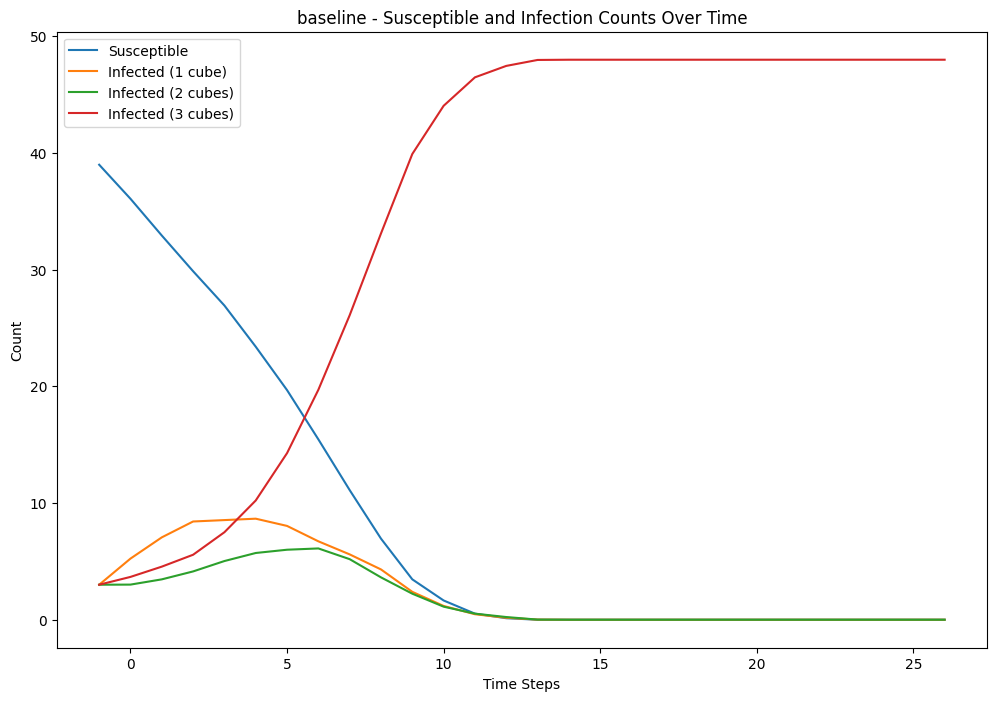

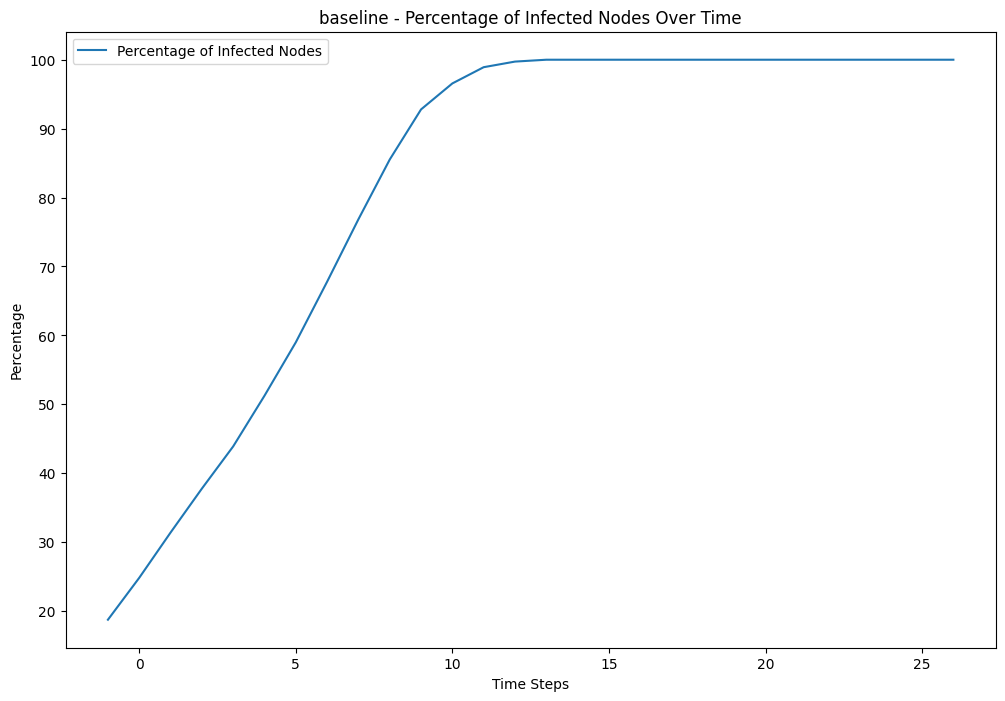

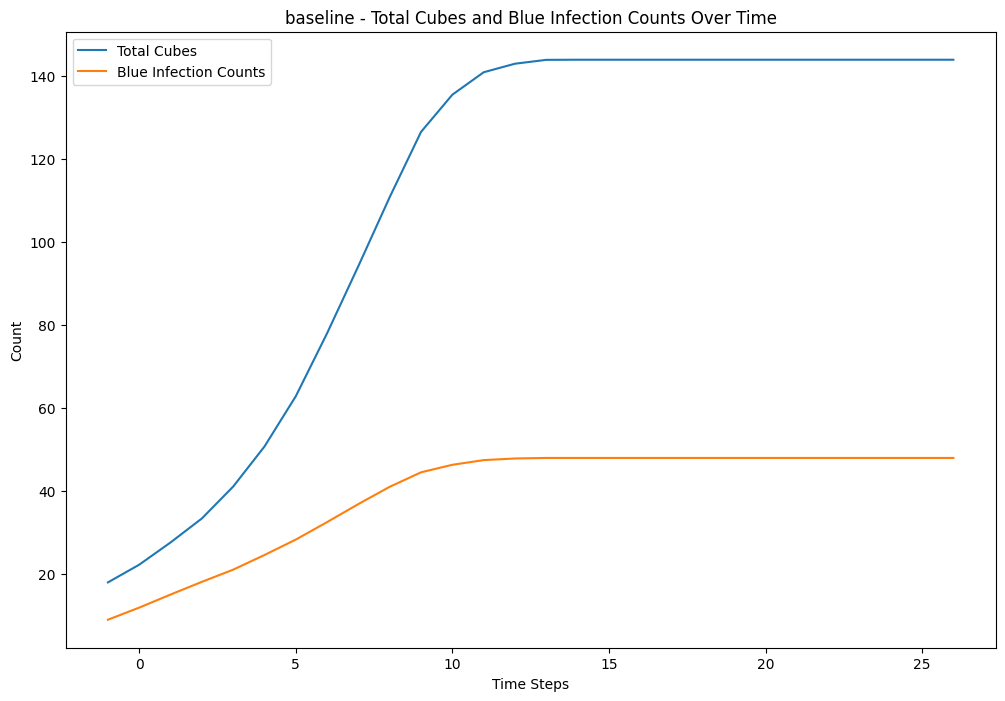

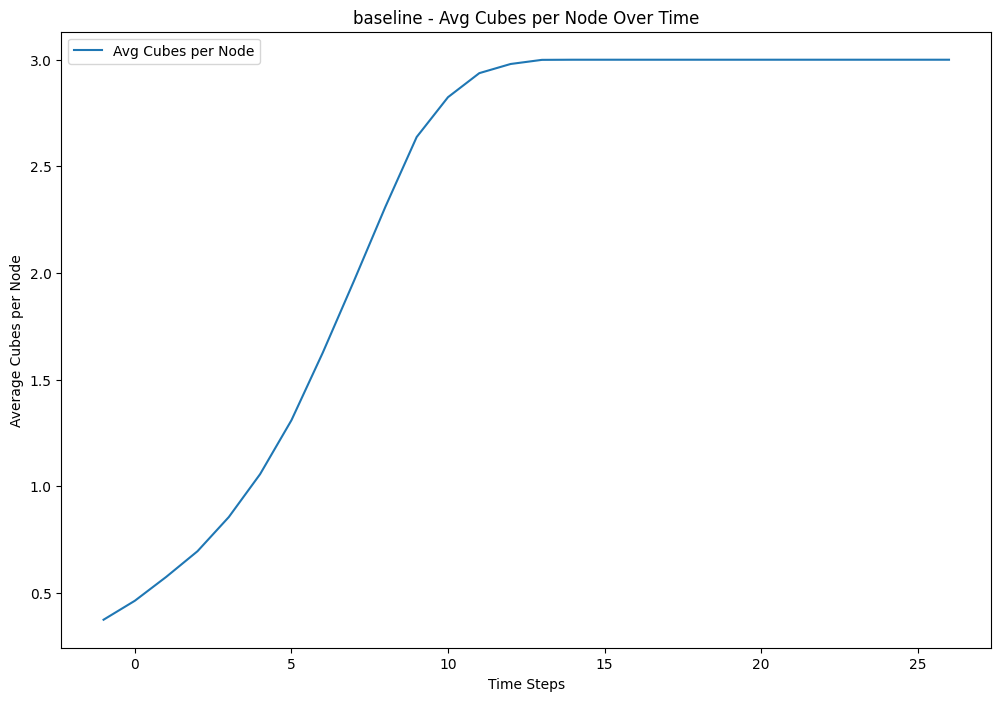

In [ ]:
df = pd.read_csv('pandemic_baseline_results.csv')

# Filter data with no_epidemic equal to 6
filtered_data = df[df['no_epidemic'] == 6]

# Group data by setup (strategy)
grouped_data = filtered_data.groupby('setup')

# Function to calculate average susceptible count for each time step
def calculate_avg_susceptible(group_df):
    avg_susceptible = group_df.groupby('timestep')['susceptible_nodes'].mean()
    return avg_susceptible

# Function to calculate average counts of infected nodes (1, 2, and 3 cubes) for each time step
def calculate_avg_infected(group_df):
    avg_infected_1 = group_df.groupby('timestep')['infection_1_nodes'].mean()
    avg_infected_2 = group_df.groupby('timestep')['infection_2_nodes'].mean()
    avg_infected_3 = group_df.groupby('timestep')['infection_3_nodes'].mean()
    return avg_infected_1, avg_infected_2, avg_infected_3

# Function to calculate average percentage of infected nodes for each time step
def calculate_avg_percentage_infected(group_df):
    total_nodes = 48
    a1, a2, a3 = calculate_avg_infected(group_df)
    avg_percentage_infected = ((a1 + a2 + a3) / total_nodes) * 100
    return avg_percentage_infected

# Function to calculate average total cubes and blue infection counts for each time step
def calculate_avg_cubes_and_blue_infection(group_df):
    total_nodes = 48
    a1, a2, a3 = calculate_avg_infected(group_df)
    avg_total_cubes = a1 + 2 * a2 + a3 * 3
    avg_blue_infection = a1+a2+a3
    return avg_total_cubes, avg_blue_infection

# Function to calculate average cubes per node for each time step
def calculate_avg_cubes_per_node(group_df):
    total_nodes = 48
    a1, a2, a3 = calculate_avg_infected(group_df)
    avg_total_cubes = a1 + 2 * a2 + a3 * 3
    avg_cubes_per_node = avg_total_cubes / total_nodes
    return avg_cubes_per_node

# Loop over each strategy
for strategy, group_df in grouped_data:
    # Calculate statistics
    avg_susceptible = calculate_avg_susceptible(group_df)
    avg_infected_1, avg_infected_2, avg_infected_3 = calculate_avg_infected(group_df)
    avg_percentage_infected = calculate_avg_percentage_infected(group_df)
    avg_total_cubes, avg_blue_infection = calculate_avg_cubes_and_blue_infection(group_df)
    avg_cubes_per_node = calculate_avg_cubes_per_node(group_df)

    # Plot statistics
    # Plot Susceptible and Infection Counts Over Time
    plt.figure(figsize=(12, 8))
    plt.plot(avg_susceptible.index, avg_susceptible.values, label='Susceptible')
    plt.plot(avg_infected_1.index, avg_infected_1.values, label='Infected (1 cube)')
    plt.plot(avg_infected_2.index, avg_infected_2.values, label='Infected (2 cubes)')
    plt.plot(avg_infected_3.index, avg_infected_3.values, label='Infected (3 cubes)')
    plt.xlabel('Time Steps')
    plt.ylabel('Count')
    plt.title(f'{strategy} - Susceptible and Infection Counts Over Time')
    plt.legend()
    plt.show()

    # Plot Percentage of Infected Nodes over time steps
    plt.figure(figsize=(12, 8))
    plt.plot(avg_percentage_infected.index, avg_percentage_infected.values, label='Percentage of Infected Nodes')
    plt.xlabel('Time Steps')
    plt.ylabel('Percentage')
    plt.title(f'{strategy} - Percentage of Infected Nodes Over Time')
    plt.legend()
    plt.show()

    # Plot Total Cubes and Blue Infection counts over time steps
    plt.figure(figsize=(12, 8))
    plt.plot(avg_total_cubes.index, avg_total_cubes.values, label='Total Cubes')
    plt.plot(avg_blue_infection.index, avg_blue_infection.values, label='Blue Infection Counts')
    plt.xlabel('Time Steps')
    plt.ylabel('Count')
    plt.title(f'{strategy} - Total Cubes and Blue Infection Counts Over Time')
    plt.legend()
    plt.show()

    # Plot Avg Cubes per Node over time steps
    plt.figure(figsize=(12, 8))
    plt.plot(avg_cubes_per_node.index, avg_cubes_per_node.values, label='Avg Cubes per Node')
    plt.xlabel('Time Steps')
    plt.ylabel('Average Cubes per Node')
    plt.title(f'{strategy} - Avg Cubes per Node Over Time')
    plt.legend()
    plt.show()

In [ ]:
# Load the CSV file
df = pd.read_csv('pandemic_all_strategies_results.csv')

# Filter data with no_epidemic equal to 6
filtered_data = df[df['no_epidemic'] == 6]

# Group data by setup (strategy)
grouped_data = filtered_data.groupby('setup')

# Function to calculate average susceptible count for each time step
def calculate_avg_susceptible(group_df):
    avg_susceptible = group_df.groupby('timestep')['susceptible_nodes'].mean()
    return avg_susceptible

# Function to calculate average counts of infected nodes (1, 2, and 3 cubes) for each time step
def calculate_avg_infected(group_df):
    avg_infected_1 = group_df.groupby('timestep')['infection_1_nodes'].mean()
    avg_infected_2 = group_df.groupby('timestep')['infection_2_nodes'].mean()
    avg_infected_3 = group_df.groupby('timestep')['infection_3_nodes'].mean()
    return avg_infected_1, avg_infected_2, avg_infected_3

# Function to calculate average percentage of infected nodes for each time step
def calculate_avg_percentage_infected(group_df):
    total_nodes = 48
    a1, a2, a3 = calculate_avg_infected(group_df)
    avg_percentage_infected = ((a1 + a2 + a3) / total_nodes) * 100
    return avg_percentage_infected

# Function to calculate average total cubes and blue infection counts for each time step
def calculate_avg_cubes_and_blue_infection(group_df):
    total_nodes = 48
    a1, a2, a3 = calculate_avg_infected(group_df)
    avg_total_cubes = a1 + 2 * a2 + a3 * 3
    avg_blue_infection = a1+a2+a3
    return avg_total_cubes, avg_blue_infection

# Function to calculate average cubes per node for each time step
def calculate_avg_cubes_per_node(group_df):
    total_nodes = 48
    a1, a2, a3 = calculate_avg_infected(group_df)
    avg_total_cubes = a1 + 2 * a2 + a3 * 3
    avg_cubes_per_node = avg_total_cubes / total_nodes
    return avg_cubes_per_node

# Loop over each strategy and k_action
for k_action in k_actions_range:
    for strategy, group_df in grouped_data:
        # Filter data for the current k_action
        group_df_k_action = group_df[group_df['k_actions'] == k_action]

        # Calculate statistics
        avg_susceptible = calculate_avg_susceptible(group_df_k_action)
        avg_infected_1, avg_infected_2, avg_infected_3 = calculate_avg_infected(group_df_k_action)
        avg_percentage_infected = calculate_avg_percentage_infected(group_df_k_action)
        avg_total_cubes, avg_blue_infection = calculate_avg_cubes_and_blue_infection(group_df_k_action)
        avg_cubes_per_node = calculate_avg_cubes_per_node(group_df_k_action)

        # Plot statistics
        # Plot Susceptible and Infection Counts Over Time
        plt.figure(figsize=(12, 8))
        plt.plot(avg_susceptible.index, avg_susceptible.values, label='Susceptible')
        plt.plot(avg_infected_1.index, avg_infected_1.values, label='Infected (1 cube)')
        plt.plot(avg_infected_2.index, avg_infected_2.values, label='Infected (2 cubes)')
        plt.plot(avg_infected_3.index, avg_infected_3.values, label='Infected (3 cubes)')
        plt.xlabel('Time Steps')
        plt.ylabel('Count')
        plt.title(f'{strategy} - Susceptible and Infection Counts Over Time (k_action={k_action})')
        plt.legend()
        plt.show()

        # Plot Percentage of Infected Nodes over time steps
        plt.figure(figsize=(12, 8))
        plt.plot(avg_percentage_infected.index, avg_percentage_infected.values, label='Percentage of Infected Nodes')
        plt.xlabel('Time Steps')
        plt.ylabel('Percentage')
        plt.title(f'{strategy} - Percentage of Infected Nodes Over Time (k_action={k_action})')
        plt.legend()
        plt.show()

        # Plot Total Cubes and Blue Infection counts over time steps
        plt.figure(figsize=(12, 8))
        plt.plot(avg_total_cubes.index, avg_total_cubes.values, label='Total Cubes')
        plt.plot(avg_blue_infection.index, avg_blue_infection.values, label='Blue Infection Counts')
        plt.xlabel('Time Steps')
        plt.ylabel('Count')
        plt.title(f'{strategy} - Total Cubes and Blue Infection Counts Over Time (k_action={k_action})')
        plt.legend()
        plt.show()

        # Plot Avg Cubes per Node over time steps
        plt.figure(figsize=(12, 8))
        plt.plot(avg_cubes_per_node.index, avg_cubes_per_node.values, label='Avg Cubes per Node')
        plt.xlabel('Time Steps')
        plt.ylabel('Average Cubes per Node')
        plt.title(f'{strategy} - Avg Cubes per Node Over Time (k_action={k_action})')
        plt.legend()
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

For the Dataset with working Outbreaks

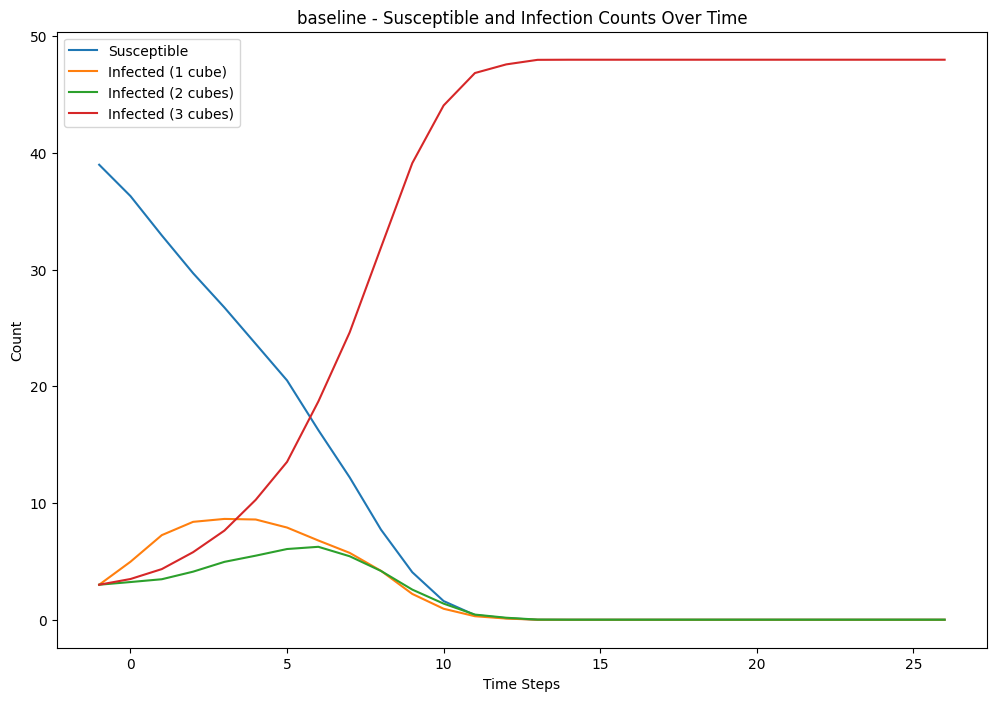

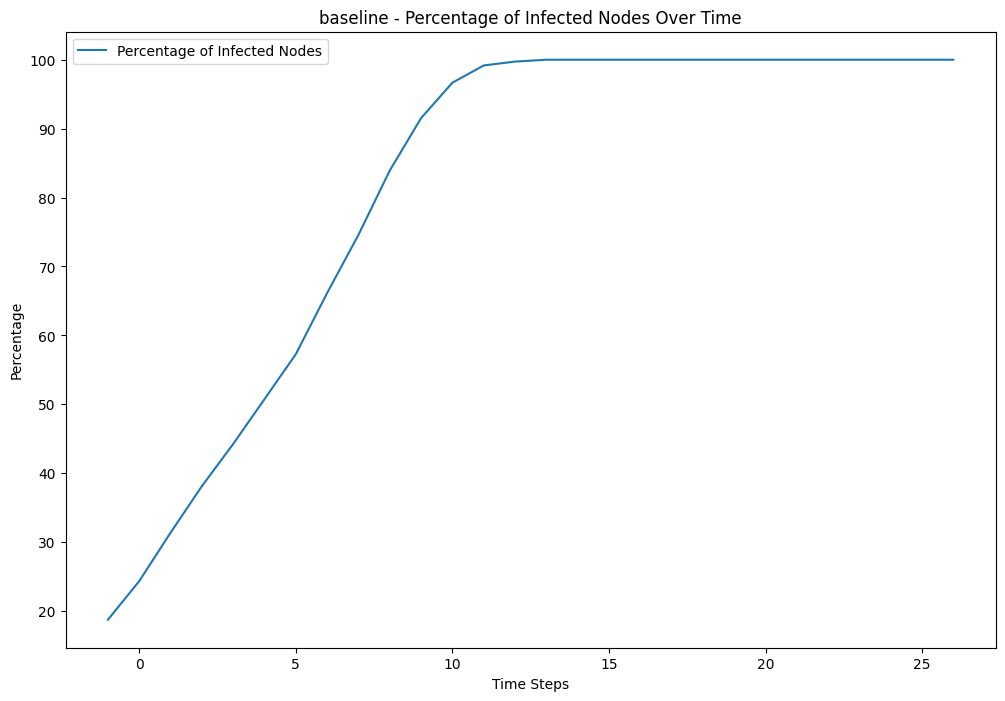

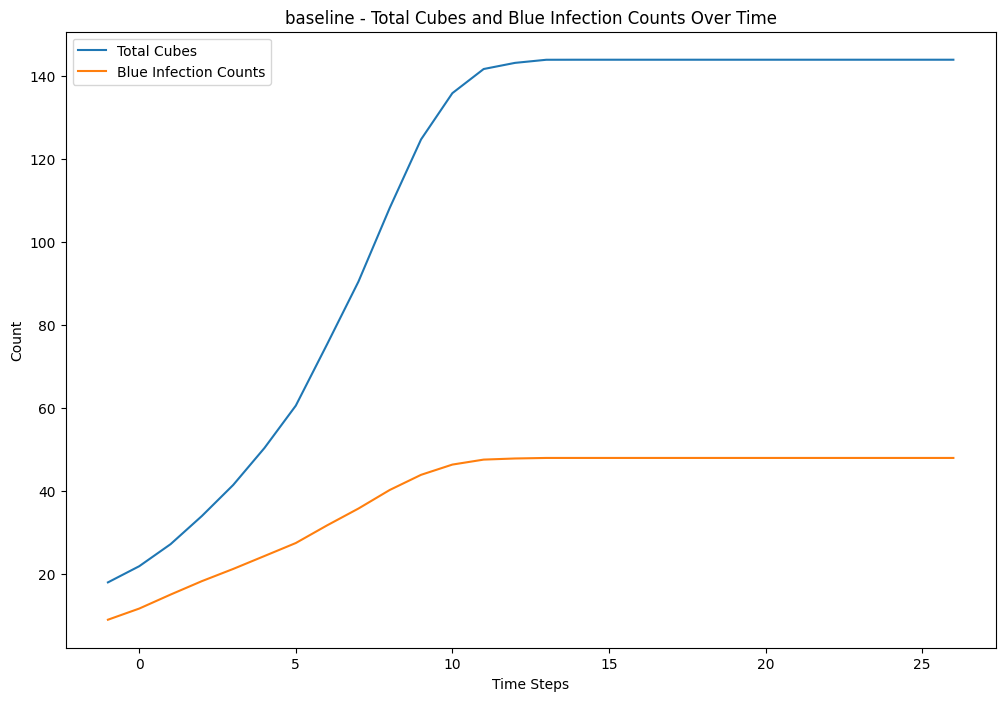

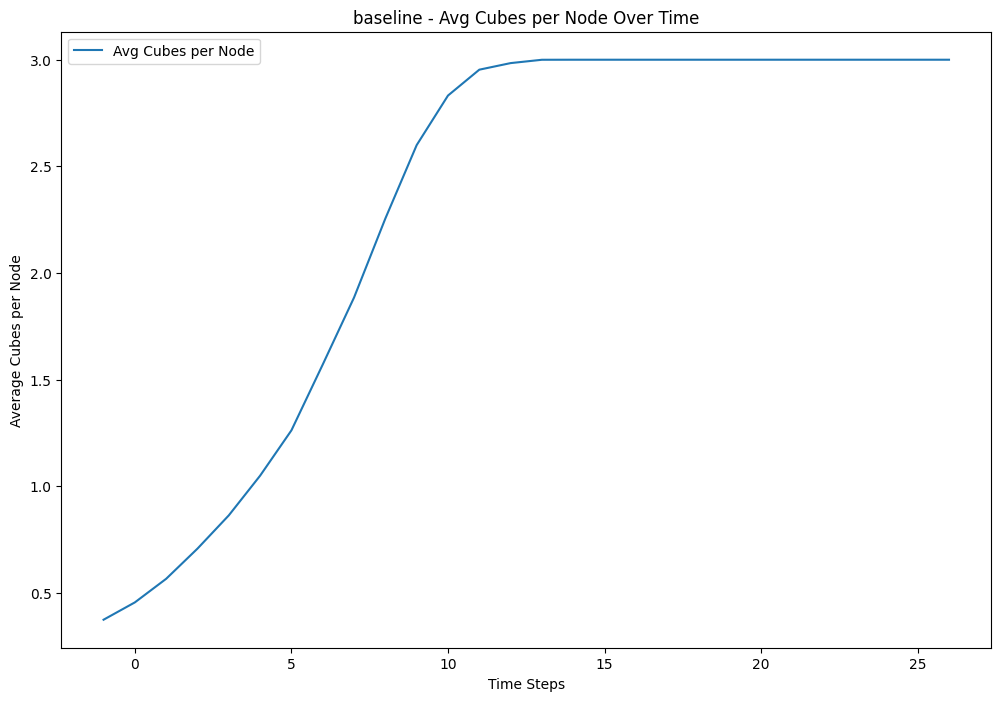

In [ ]:
df = pd.read_csv('pandemic_baseline_results2.csv')

# Filter data with no_epidemic equal to 6
filtered_data = df[df['no_epidemic'] == 6]

# Group data by setup (strategy)
grouped_data = filtered_data.groupby('setup')

# Function to calculate average susceptible count for each time step
def calculate_avg_susceptible(group_df):
    avg_susceptible = group_df.groupby('timestep')['susceptible_nodes'].mean()
    return avg_susceptible

# Function to calculate average counts of infected nodes (1, 2, and 3 cubes) for each time step
def calculate_avg_infected(group_df):
    avg_infected_1 = group_df.groupby('timestep')['infection_1_nodes'].mean()
    avg_infected_2 = group_df.groupby('timestep')['infection_2_nodes'].mean()
    avg_infected_3 = group_df.groupby('timestep')['infection_3_nodes'].mean()
    return avg_infected_1, avg_infected_2, avg_infected_3

# Function to calculate average percentage of infected nodes for each time step
def calculate_avg_percentage_infected(group_df):
    total_nodes = 48
    a1, a2, a3 = calculate_avg_infected(group_df)
    avg_percentage_infected = ((a1 + a2 + a3) / total_nodes) * 100
    return avg_percentage_infected

# Function to calculate average total cubes and blue infection counts for each time step
def calculate_avg_cubes_and_blue_infection(group_df):
    total_nodes = 48
    a1, a2, a3 = calculate_avg_infected(group_df)
    avg_total_cubes = a1 + 2 * a2 + a3 * 3
    avg_blue_infection = a1+a2+a3
    return avg_total_cubes, avg_blue_infection

# Function to calculate average cubes per node for each time step
def calculate_avg_cubes_per_node(group_df):
    total_nodes = 48
    a1, a2, a3 = calculate_avg_infected(group_df)
    avg_total_cubes = a1 + 2 * a2 + a3 * 3
    avg_cubes_per_node = avg_total_cubes / total_nodes
    return avg_cubes_per_node

# Loop over each strategy
for strategy, group_df in grouped_data:
    # Calculate statistics
    avg_susceptible = calculate_avg_susceptible(group_df)
    avg_infected_1, avg_infected_2, avg_infected_3 = calculate_avg_infected(group_df)
    avg_percentage_infected = calculate_avg_percentage_infected(group_df)
    avg_total_cubes, avg_blue_infection = calculate_avg_cubes_and_blue_infection(group_df)
    avg_cubes_per_node = calculate_avg_cubes_per_node(group_df)

    # Plot statistics
    # Plot Susceptible and Infection Counts Over Time
    plt.figure(figsize=(12, 8))
    plt.plot(avg_susceptible.index, avg_susceptible.values, label='Susceptible')
    plt.plot(avg_infected_1.index, avg_infected_1.values, label='Infected (1 cube)')
    plt.plot(avg_infected_2.index, avg_infected_2.values, label='Infected (2 cubes)')
    plt.plot(avg_infected_3.index, avg_infected_3.values, label='Infected (3 cubes)')
    plt.xlabel('Time Steps')
    plt.ylabel('Count')
    plt.title(f'{strategy} - Susceptible and Infection Counts Over Time')
    plt.legend()
    plt.show()

    # Plot Percentage of Infected Nodes over time steps
    plt.figure(figsize=(12, 8))
    plt.plot(avg_percentage_infected.index, avg_percentage_infected.values, label='Percentage of Infected Nodes')
    plt.xlabel('Time Steps')
    plt.ylabel('Percentage')
    plt.title(f'{strategy} - Percentage of Infected Nodes Over Time')
    plt.legend()
    plt.show()

    # Plot Total Cubes and Blue Infection counts over time steps
    plt.figure(figsize=(12, 8))
    plt.plot(avg_total_cubes.index, avg_total_cubes.values, label='Total Cubes')
    plt.plot(avg_blue_infection.index, avg_blue_infection.values, label='Blue Infection Counts')
    plt.xlabel('Time Steps')
    plt.ylabel('Count')
    plt.title(f'{strategy} - Total Cubes and Blue Infection Counts Over Time')
    plt.legend()
    plt.show()

    # Plot Avg Cubes per Node over time steps
    plt.figure(figsize=(12, 8))
    plt.plot(avg_cubes_per_node.index, avg_cubes_per_node.values, label='Avg Cubes per Node')
    plt.xlabel('Time Steps')
    plt.ylabel('Average Cubes per Node')
    plt.title(f'{strategy} - Avg Cubes per Node Over Time')
    plt.legend()
    plt.show()

In [ ]:
# Load the CSV file
df = pd.read_csv('pandemic_all_strategies_results2.csv')

# Filter data with no_epidemic equal to 6
filtered_data = df[df['no_epidemic'] == 6]

# Group data by setup (strategy)
grouped_data = filtered_data.groupby('setup')

# Function to calculate average susceptible count for each time step
def calculate_avg_susceptible(group_df):
    avg_susceptible = group_df.groupby('timestep')['susceptible_nodes'].mean()
    return avg_susceptible

# Function to calculate average counts of infected nodes (1, 2, and 3 cubes) for each time step
def calculate_avg_infected(group_df):
    avg_infected_1 = group_df.groupby('timestep')['infection_1_nodes'].mean()
    avg_infected_2 = group_df.groupby('timestep')['infection_2_nodes'].mean()
    avg_infected_3 = group_df.groupby('timestep')['infection_3_nodes'].mean()
    return avg_infected_1, avg_infected_2, avg_infected_3

# Function to calculate average percentage of infected nodes for each time step
def calculate_avg_percentage_infected(group_df):
    total_nodes = 48
    a1, a2, a3 = calculate_avg_infected(group_df)
    avg_percentage_infected = ((a1 + a2 + a3) / total_nodes) * 100
    return avg_percentage_infected

# Function to calculate average total cubes and blue infection counts for each time step
def calculate_avg_cubes_and_blue_infection(group_df):
    total_nodes = 48
    a1, a2, a3 = calculate_avg_infected(group_df)
    avg_total_cubes = a1 + 2 * a2 + a3 * 3
    avg_blue_infection = a1+a2+a3
    return avg_total_cubes, avg_blue_infection

# Function to calculate average cubes per node for each time step
def calculate_avg_cubes_per_node(group_df):
    total_nodes = 48
    a1, a2, a3 = calculate_avg_infected(group_df)
    avg_total_cubes = a1 + 2 * a2 + a3 * 3
    avg_cubes_per_node = avg_total_cubes / total_nodes
    return avg_cubes_per_node

# Loop over each strategy and k_action
for k_action in k_actions_range:
    for strategy, group_df in grouped_data:
        # Filter data for the current k_action
        group_df_k_action = group_df[group_df['k_actions'] == k_action]

        # Calculate statistics
        avg_susceptible = calculate_avg_susceptible(group_df_k_action)
        avg_infected_1, avg_infected_2, avg_infected_3 = calculate_avg_infected(group_df_k_action)
        avg_percentage_infected = calculate_avg_percentage_infected(group_df_k_action)
        avg_total_cubes, avg_blue_infection = calculate_avg_cubes_and_blue_infection(group_df_k_action)
        avg_cubes_per_node = calculate_avg_cubes_per_node(group_df_k_action)

        # Plot statistics
        # Plot Susceptible and Infection Counts Over Time
        plt.figure(figsize=(12, 8))
        plt.plot(avg_susceptible.index, avg_susceptible.values, label='Susceptible')
        plt.plot(avg_infected_1.index, avg_infected_1.values, label='Infected (1 cube)')
        plt.plot(avg_infected_2.index, avg_infected_2.values, label='Infected (2 cubes)')
        plt.plot(avg_infected_3.index, avg_infected_3.values, label='Infected (3 cubes)')
        plt.xlabel('Time Steps')
        plt.ylabel('Count')
        plt.title(f'{strategy} - Susceptible and Infection Counts Over Time (k_action={k_action})')
        plt.legend()
        plt.show()

        # Plot Percentage of Infected Nodes over time steps
        plt.figure(figsize=(12, 8))
        plt.plot(avg_percentage_infected.index, avg_percentage_infected.values, label='Percentage of Infected Nodes')
        plt.xlabel('Time Steps')
        plt.ylabel('Percentage')
        plt.title(f'{strategy} - Percentage of Infected Nodes Over Time (k_action={k_action})')
        plt.legend()
        plt.show()

        # Plot Total Cubes and Blue Infection counts over time steps
        plt.figure(figsize=(12, 8))
        plt.plot(avg_total_cubes.index, avg_total_cubes.values, label='Total Cubes')
        plt.plot(avg_blue_infection.index, avg_blue_infection.values, label='Blue Infection Counts')
        plt.xlabel('Time Steps')
        plt.ylabel('Count')
        plt.title(f'{strategy} - Total Cubes and Blue Infection Counts Over Time (k_action={k_action})')
        plt.legend()
        plt.show()

        # Plot Avg Cubes per Node over time steps
        plt.figure(figsize=(12, 8))
        plt.plot(avg_cubes_per_node.index, avg_cubes_per_node.values, label='Avg Cubes per Node')
        plt.xlabel('Time Steps')
        plt.ylabel('Average Cubes per Node')
        plt.title(f'{strategy} - Avg Cubes per Node Over Time (k_action={k_action})')
        plt.legend()
        plt.show()


Output hidden; open in https://colab.research.google.com to view.